In [87]:
%load_ext autoreload
%autoreload 1
import os
import pandas as pd
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch
import modelos
%aimport modelos
import model_utils
%aimport model_utils
import dataset_mio
%aimport dataset_mio
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate dataset

In [63]:
files = [f.split('.')[0] for f in os.listdir('./') if f.split('.')[1] == 'jsonl']
files.sort()
files

['Fer 2025-01-10 16h29m09s',
 'Fer 2025-01-10 16h30m36s',
 'Fer 2025-01-10 16h31m44s',
 'Fer 2025-01-10 16h33m14s',
 'Fer 2025-01-10 16h34m26s',
 'Fer 2025-01-10 16h36m22s',
 'Fer 2025-01-10 16h37m41s',
 'Fer 2025-01-10 16h39m07s',
 'Fer 2025-01-10 16h40m43s',
 'Fer 2025-01-10 16h42m18s']

In [105]:
df = []
video_df = cv2.VideoWriter('dataset.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, (224, 224))
for i, name in enumerate(files):
    j = 0
    video = cv2.VideoCapture(f'{name}.mp4')
    with open(f"{name}.jsonl", "r") as file:
        for line in file:
            # Actions
            jsonl = json.loads(line.replace('infinity', 'null'))
            jsonl['i'] = i
            jsonl['j'] = j
            j += 1
            df.append(jsonl)
            # Frames
            _, frame = video.read()
            assert(_)
            #if i == 0 and j > 2:
            resized_frame = cv2.resize(frame, (224, 224))
            video_df.write(resized_frame)
video_df.release()
len(df) # 15140

15140

In [69]:
df = pd.DataFrame(df)
df['dash'] = df['dash'].shift(-1, fill_value=False)
df['move_left'] = df['move_left'].shift(-1, fill_value=False)
df['move_right'] = df['move_right'].shift(-1, fill_value=False)
df['valid'] = (df['i'] == df['i'].shift(2))
# df = df[df['valid'] == True] # Use vide changes 
df.to_csv('dataset.csv')
df

,frame,move_left,move_right,up,down,jump,attack,dash,spell,focus,super_dash,super_dash_cancel,x,y,fps,i,j,valid
0,1,False,False,False,False,False,False,False,False,False,False,False,234.7,305.4,60.0,0,0,False
1,2,False,False,False,False,False,False,False,False,False,False,False,234.7,305.4,60.0,0,1,False
2,3,False,False,False,False,False,False,False,False,False,False,False,234.7,305.4,60.0,0,2,True
3,4,False,False,False,False,False,False,False,False,False,False,False,234.7,305.4,60.1,0,3,True
4,5,False,False,False,False,False,False,False,False,False,False,False,234.7,305.4,60.1,0,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15135,1665,False,False,False,False,False,False,False,False,False,False,False,376.6,305.4,59.9,9,1664,True
15136,1666,False,False,False,False,False,False,False,False,False,False,False,376.6,305.4,60.1,9,1665,True
15137,1667,False,False,False,False,False,False,False,False,False,False,False,376.6,305.4,60.0,9,1666,True
15138,1668,False,False,False,False,False,False,False,False,False,False,False,376.6,305.4,60.1,9,1667,True


# Visualize

In [3]:
df = pd.read_csv('dataset.csv', index_col=0)
df

,frame,move_left,move_right,up,down,jump,attack,dash,spell,focus,super_dash,super_dash_cancel,x,y,fps,i,j,valid
0,1,False,False,False,False,False,False,False,False,False,False,False,234.7,305.4,60.0,0,0,False
1,2,False,False,False,False,False,False,False,False,False,False,False,234.7,305.4,60.0,0,1,False
2,3,False,False,False,False,False,False,False,False,False,False,False,234.7,305.4,60.0,0,2,True
3,4,False,False,False,False,False,False,False,False,False,False,False,234.7,305.4,60.1,0,3,True
4,5,False,False,False,False,False,False,False,False,False,False,False,234.7,305.4,60.1,0,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15135,1665,False,False,False,False,False,False,False,False,False,False,False,376.6,305.4,59.9,9,1664,True
15136,1666,False,False,False,False,False,False,False,False,False,False,False,376.6,305.4,60.1,9,1665,True
15137,1667,False,False,False,False,False,False,False,False,False,False,False,376.6,305.4,60.0,9,1666,True
15138,1668,False,False,False,False,False,False,False,False,False,False,False,376.6,305.4,60.1,9,1667,True


In [40]:
def plot_image(i):
    frames = []  # List to store 3 consecutive frames
    video = cv2.VideoCapture('dataset.mp4')
    video.set(cv2.CAP_PROP_POS_FRAMES, i-2)
    # Read 3 consecutive frames
    for _ in range(3):
        ret, frame = video.read()
        if not ret:  # If no more frames, exit loop
            break
        frames.append(frame)
    stacked_frame = np.hstack(frames) 
    # Display the stacked frames
    plt.figure(figsize=(15, 6))
    plt.title(df.loc[i])
    plt.imshow(stacked_frame)
    plt.axis('off')  # Hide axes
    plt.show()
    video.release()

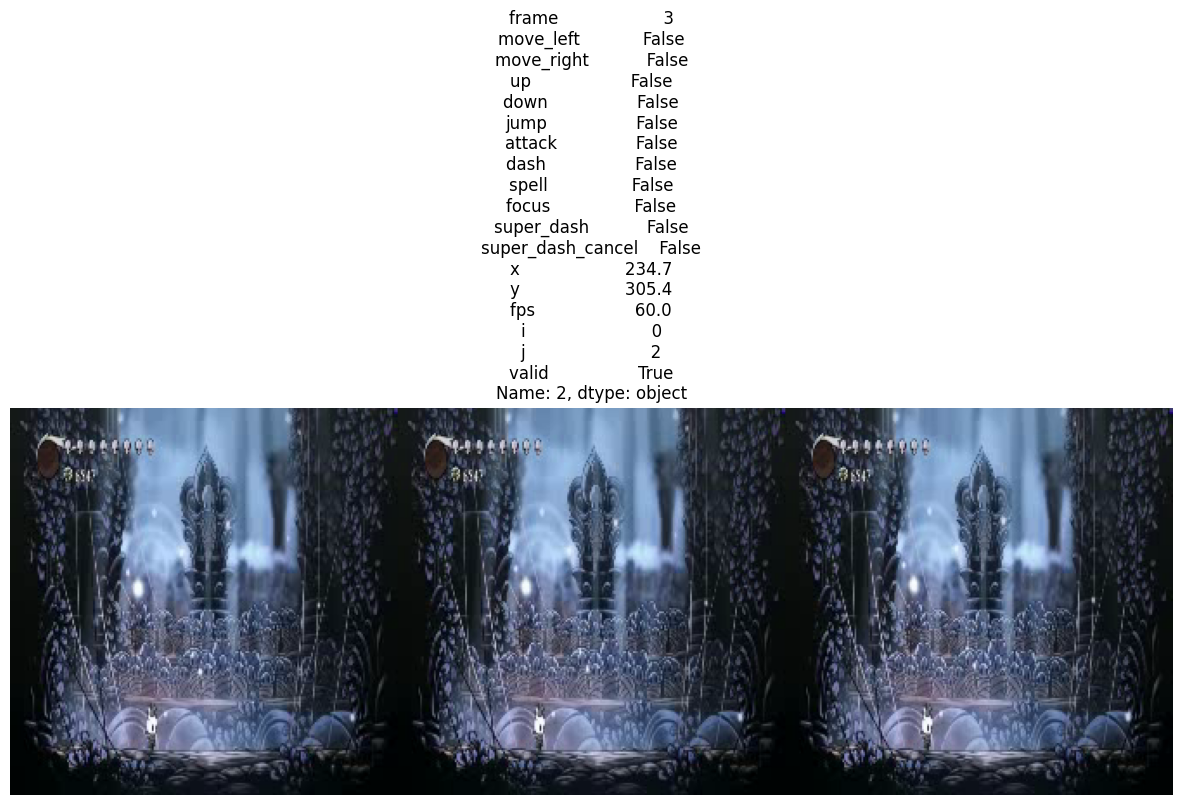

In [42]:
plot_image(2)

# Training

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actions = ['move_left', 'move_right', 'jump', 'attack', 'dash', 'spell', 'focus']

In [107]:
df = pd.read_csv('dataset.csv', index_col=0)
video = cv2.VideoCapture('dataset.mp4')

In [108]:
ds = dataset_mio.LazyVideoDataset(video, df, actions)

In [126]:
batch_size = 32
train_dev_set, test_set = random_split(ds, [0.8, 0.2], generator=torch.Generator().manual_seed(29))
test_loader = DataLoader(test_set, batch_size=batch_size, pin_memory=True)
num_classes = len(actions)
learning_rate = 0.001

hidden_size = [128]
num_layers = [2]
weight_decay = 0.0
lstm_dropout = 0.2

bi = False
MAX_EPOCHS = 30
MAX_COUNTER = 6
k_folds = 5

In [127]:
def train(hidden_size, num_layers, num_classes, learning_rate, weight_decay, lstm_dropout, bi):
    s = f"hidden_size={hidden_size}, num_layers={num_layers}, num_classes={num_classes}, learning_rate={learning_rate}, weight_decay={weight_decay}, lstm_dropout={lstm_dropout}, bi={bi}"
    print(s)
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    metrics_per_fold = {}
    best_metrics_per_fold = {}
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dev_set)):
        print(f" === Fold {fold} === ")
        train_set = Subset(train_dev_set, train_ids)
        dev_set = Subset(train_dev_set, val_ids)
        
        train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=0, shuffle=True, pin_memory=True)
        dev_loader = DataLoader(dev_set, batch_size=batch_size, num_workers=0, shuffle=False, pin_memory=True)
        
        # Model
        model = modelos.ResnetModel(512, hidden_size, num_layers, num_classes, lstm_dropout=lstm_dropout, bi=bi).to(device)
        #loss_fn = nn.CrossEntropyLoss()
        loss_fn = nn.BCEWithLogitsLoss()
        #optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        print(model)
    
        # Metrics
        metrics = {
            'train' : {
                'loss' : [],
                'acc' : []
            },
            'validation' : {
                'loss' : [],
                'acc' : [],
            }
        }
        best_metrics =  {
            'epoch' : 0,
            'loss' : 1e8,
            'acc' : 0,
            'model' : model.state_dict()
        }
        
        epoch = 0
        counter = 0
        while epoch < MAX_EPOCHS and counter < MAX_COUNTER:
            start = time.time()
            # Training phase
            train_loss, train_acc = model_utils.train_step(model, train_loader, loss_fn, optimizer, device)
            metrics['train']['loss'].append(train_loss)
            metrics['train']['acc'].append(train_acc)
            
            # Validation phase
            val_loss, val_acc = model_utils.eval_step(model, dev_loader, loss_fn, device)
            metrics['validation']['loss'].append(val_loss)
            metrics['validation']['acc'].append(val_acc)
            end = time.time()
            
            if val_loss < best_metrics['loss']:
                best_metrics['epoch'] = epoch + 1
                best_metrics['loss'] = val_loss
                best_metrics['acc'] = val_acc
                best_metrics['model'] = model.state_dict()
                counter = 0
            else:
                counter += 1
        
            print(f"Epoch {epoch+1:03}/{MAX_EPOCHS}({end-start:,.2f} s)-Train loss: {train_loss:.7f}, Train acc: {100*train_acc:.4f}%, Validation loss: {val_loss:.7f}, Validation acc: {100*val_acc:.4f}%, C: {counter}")
            
            epoch += 1
            #torch.cuda.empty_cache()
        metrics_per_fold[fold] = metrics
        best_metrics_per_fold[fold] = best_metrics
        
        print(f" --- Best epoch {best_metrics['epoch']} --- ")
        print(f" --- Best loss {best_metrics['loss']} --- ")
        print(f" --- Best acc {best_metrics['acc']} --- ")
        torch.save(best_metrics['model'], f'./results/{name}_model_{fold}_{s}.pt')
        if fold == 0:
            break
    
    # Save metrics
    with open(f'./results/{name}_metrics_{s}.json', 'w') as f:
        json.dump(metrics_per_fold, f, indent=4)

In [128]:
for h in hidden_size:
    for l in num_layers:
        train(h, l, num_classes, learning_rate, weight_decay, lstm_dropout, bi)

hidden_size=128, num_layers=2, num_classes=7, learning_rate=0.001, weight_decay=0.0, lstm_dropout=0.2, bi=False
 === Fold 0 === 
ResnetModel(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_

FileNotFoundError: [Errno 2] No such file or directory: '/results/Fer 2025-01-10 16h42m18s_metrics_hidden_size=128, num_layers=2, num_classes=7, learning_rate=0.001, weight_decay=0.0, lstm_dropout=0.2, bi=False.json'

In [120]:
with open(f'./results/{name}_metrics.json', 'r') as f:
    metrics_per_fold = json.load(f)

# Eval
for f in metrics_per_fold:
    plt.plot(metrics_per_fold[f]['train']['loss'], label=f'Train {f}')
plt.legend()
plt.title("Loss over epochs")
plt.show()

for f in metrics_per_fold:
    plt.plot(metrics_per_fold[f]['validation']['loss'], label=f'Val {f}')
plt.legend()
plt.title("Loss over epochs")
plt.show()

for f in metrics_per_fold:
    plt.plot(metrics_per_fold[f]['train']['acc'], label=f'Train {f}')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

for f in metrics_per_fold:
    plt.plot(metrics_per_fold[f]['validation']['acc'], label=f'Val {f}')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/results/Fer 2025-01-10 16h42m18s_metrics.json'

Accuracy: 81.40
              precision    recall  f1-score   support

   move_left       0.92      0.85      0.88      1000
  move_right       0.83      0.89      0.86      1046
        jump       0.93      0.78      0.85       137
      attack       0.83      0.60      0.70       118
        dash       1.00      0.78      0.88        69
       spell       0.93      0.53      0.67        53
       focus       0.94      0.91      0.92        64

   micro avg       0.88      0.85      0.86      2487
   macro avg       0.91      0.76      0.82      2487
weighted avg       0.88      0.85      0.86      2487
 samples avg       0.91      0.89      0.83      2487



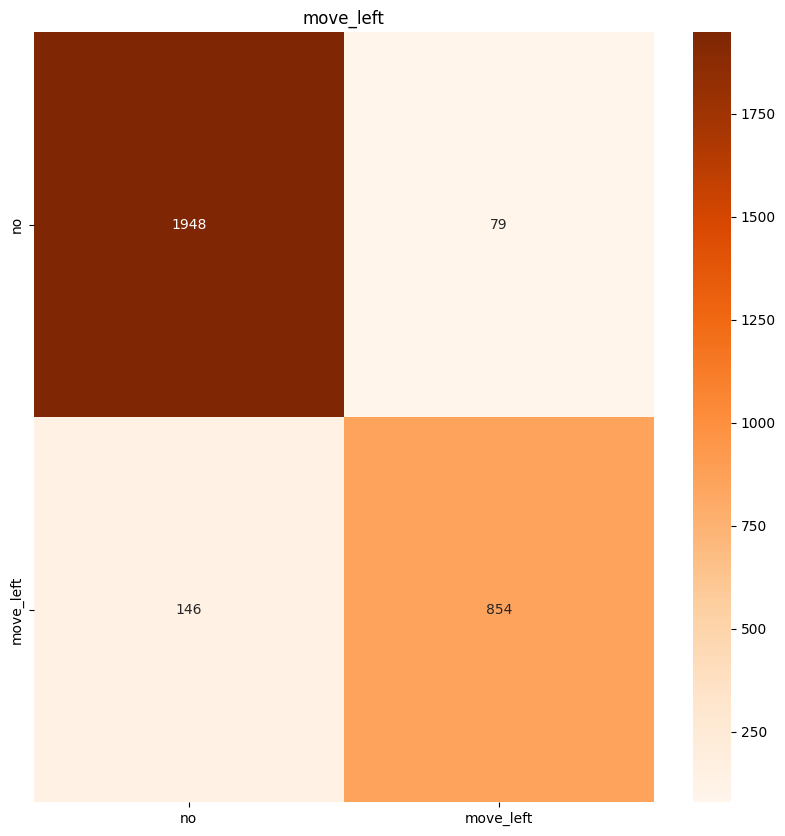

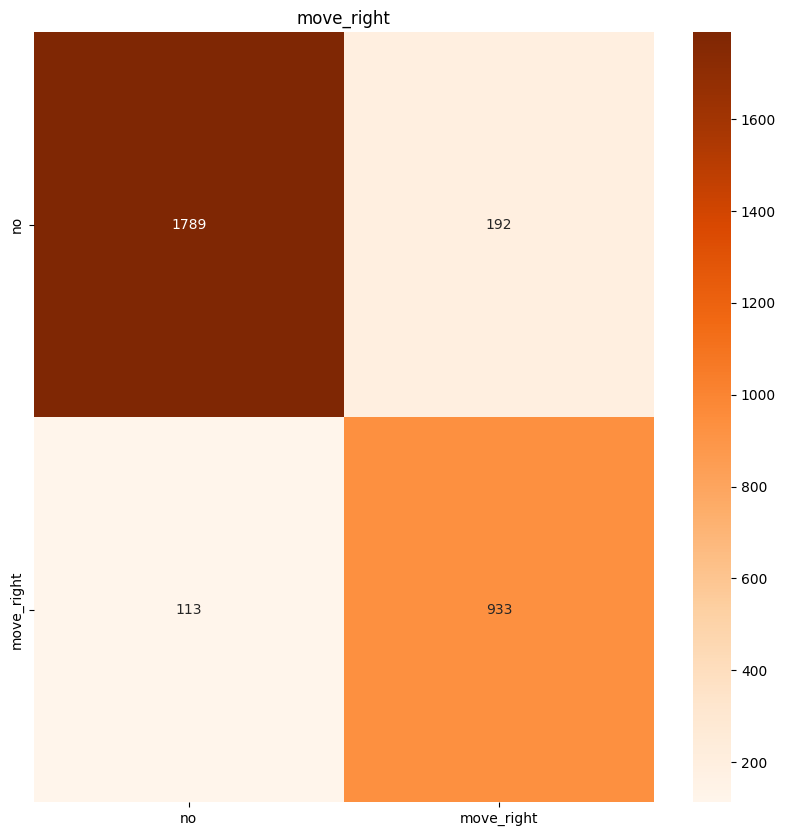

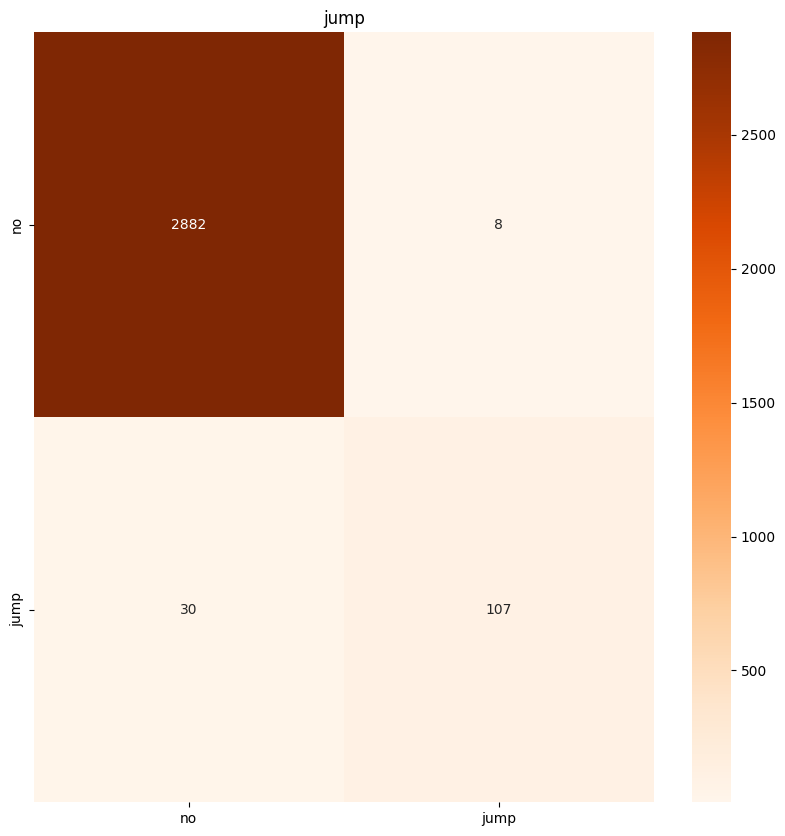

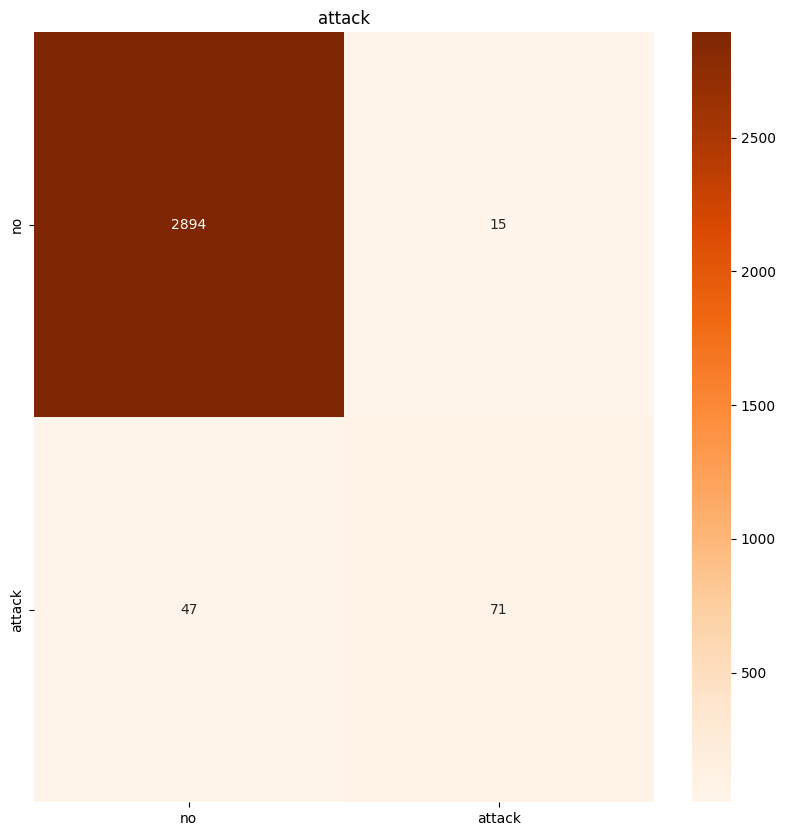

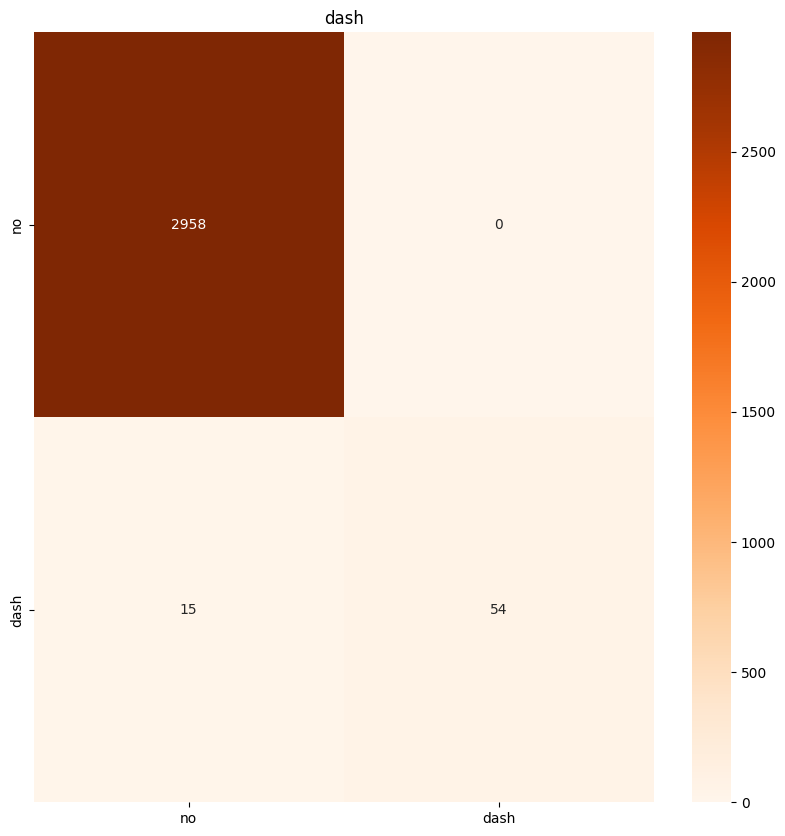

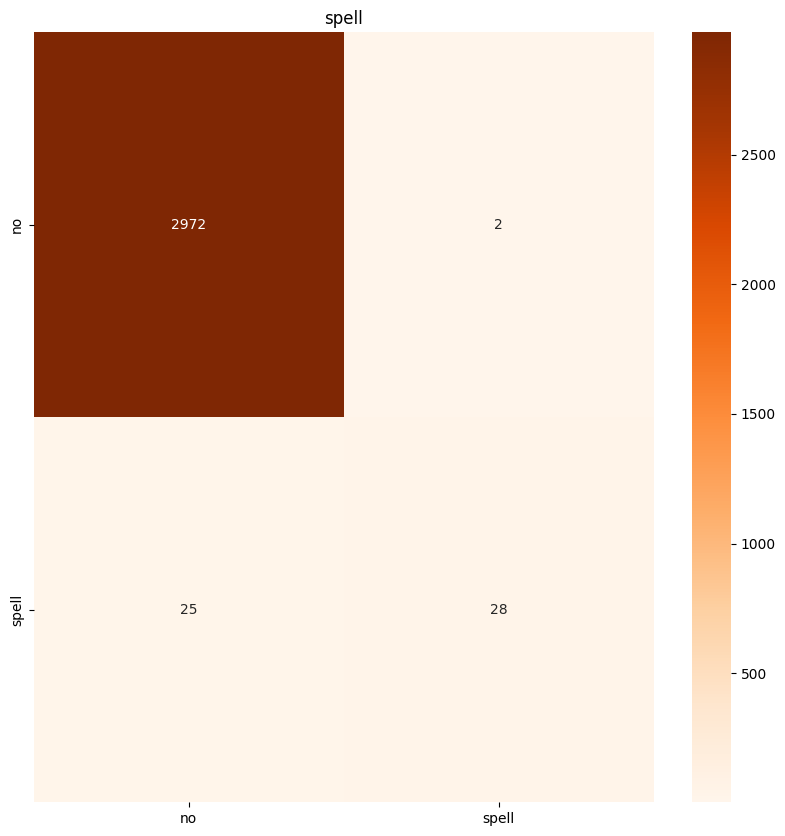

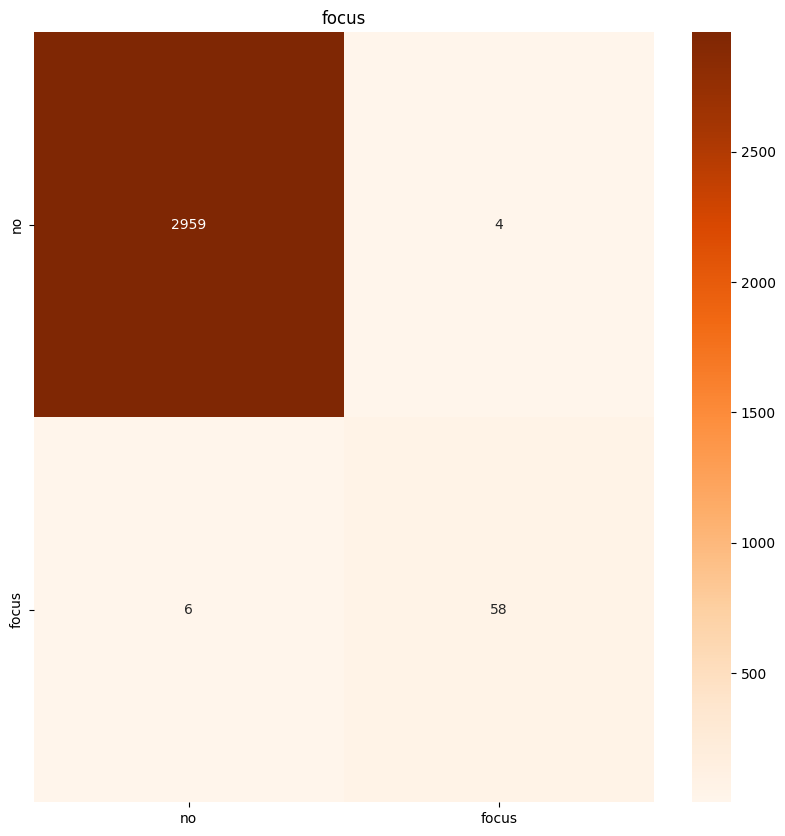

In [131]:
#Test HACER QUE SEA UN SOLO ARCHIVO
best_fold = 0
best_model_w = torch.load(f'./results/Fer 2025-01-10 16h42m18s_model_0_hidden_size=128, num_layers=2, num_classes=7, learning_rate=0.001, weight_decay=0.0, lstm_dropout=0.2, bi=False.pt', weights_only=True)
best_model = modelos.ResnetModel(512, 128, 2, 7, lstm_dropout=0.2, bi=bi).to(device)
best_model.load_state_dict(best_model_w)
train_pred, train_labels = model_utils.eval_multilabel(best_model, test_loader, actions=actions)